C:\Users\omrib\my_python\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


--- Start Pre-training (Fitting BC/IC only) ---
Pretrain Epoch 0: Loss Data: 0.78159
Pretrain Epoch 200: Loss Data: 0.06196
Pretrain Epoch 400: Loss Data: 0.00459
Pretrain Epoch 600: Loss Data: 0.00183
Pretrain Epoch 800: Loss Data: 0.00048
--- Pre-training done (2.4 sec). Starting Physics training ---
Physics Epoch 0: Total: 1.07110, Data: 0.00014, PDE: 1.07096
Physics Epoch 200: Total: 0.10050, Data: 0.06698, PDE: 0.03352
Physics Epoch 400: Total: 0.09352, Data: 0.06400, PDE: 0.02952
Physics Epoch 600: Total: 0.08812, Data: 0.06097, PDE: 0.02714
Physics Epoch 800: Total: 0.08074, Data: 0.05582, PDE: 0.02492
Physics Epoch 1000: Total: 0.07692, Data: 0.05261, PDE: 0.02431
Physics Epoch 1200: Total: 0.07426, Data: 0.05084, PDE: 0.02342
Physics Epoch 1400: Total: 0.07167, Data: 0.04931, PDE: 0.02235
Physics Epoch 1600: Total: 0.06892, Data: 0.04792, PDE: 0.02100
Physics Epoch 1800: Total: 0.06618, Data: 0.04655, PDE: 0.01962
--- Training Finished ---


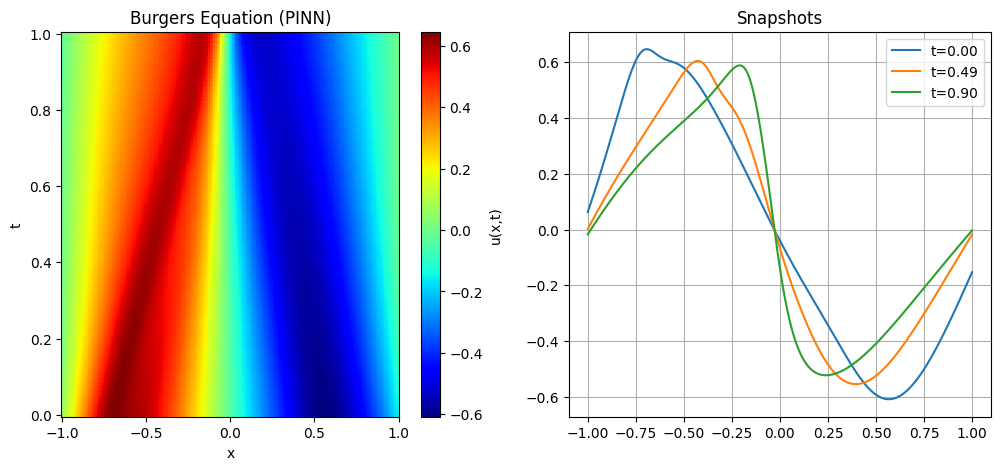

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# === הגדרות כלליות ===
tf.random.set_seed(42)
np.random.seed(42)
DTYPE = tf.float32

# פרמטרים למשוואה
VISCOSITY = 0.001  # נוזל צמיג (Burgers' Equation)

# === 1. יצירת הדאטה ===
def get_data(N_data, N_pde):
    """
    N_data: מספר נקודות על השפה והתחלה (BC + IC)
    N_pde: מספר נקודות קולוקציה בתוך התחום (Collocation Points)
    """
    
    # --- תנאי התחלה (Initial Condition): t=0, x in [-1, 1] ---
    # נשתמש ב- -sin(pi*x) שהוא הסטנדרט למשוואת בורגרס
    x_ic = np.random.uniform(-1, 1, N_data // 2).reshape(-1, 1)
    t_ic = np.zeros_like(x_ic)
    u_ic = -np.sin(np.pi * x_ic) 
    X_ic = np.hstack([x_ic, t_ic])
    
    # --- תנאי שפה (Boundary Conditions): x=-1 or x=1, t in [0, 1] ---
    t_bc = np.random.uniform(0, 1, N_data // 2).reshape(-1, 1)
    x_bc = np.random.choice([-1.0, 1.0], N_data // 2).reshape(-1, 1)
    u_bc = np.zeros_like(t_bc) # u=0 בקצוות
    X_bc = np.hstack([x_bc, t_bc])
    
    # איחוד דאטה לאימון (IC + BC)
    X_data = np.vstack([X_ic, X_bc])
    u_data = np.vstack([u_ic, u_bc])
    
    # --- נקודות קולוקציה (PDE Points): בתוך התחום ---
    x_pde = np.random.uniform(-1, 1, N_pde).reshape(-1, 1)
    t_pde = np.random.uniform(0, 1, N_pde).reshape(-1, 1)
    X_pde = np.hstack([x_pde, t_pde])
    
    # המרה לטנזורים של TF
    X_data = tf.convert_to_tensor(X_data, dtype=DTYPE)
    u_data = tf.convert_to_tensor(u_data, dtype=DTYPE)
    X_pde = tf.convert_to_tensor(X_pde, dtype=DTYPE)
    
    return X_data, u_data, X_pde

# === 2. בניית המודל ===
def init_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(2,)))
    
    # רשת עמוקה יותר עם שפעול tanh
    for _ in range(4):
        model.add(tf.keras.layers.Dense(20, activation='tanh', 
                                        kernel_initializer='glorot_normal'))
    
    model.add(tf.keras.layers.Dense(1, activation=None)) # יציאה לינארית
    return model

# === 3. צעד אימון (Vectorized & Compiled) ===
@tf.function
def train_step(model, optimizer, x_data, y_data, x_pde, apply_pde_loss):
    
    with tf.GradientTape() as tape:
        # --- חלק 1: Loss על הדאטה (תמיד פעיל) ---
        u_pred_data = model(x_data)
        loss_data = tf.reduce_mean(tf.square(y_data - u_pred_data))
        
        loss_pde = tf.constant(0.0, dtype=DTYPE)
        
        # --- חלק 2: Loss פיזיקלי (פעיל רק בשלב השני) ---
        if apply_pde_loss:
            # חישוב נגזרות אוטומטי
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_pde)
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(x_pde)
                    u = model(x_pde)
                
                # נגזרות ראשונות (x, t)
                grads = tape1.gradient(u, x_pde)
                u_x = grads[:, 0:1]
                u_t = grads[:, 1:2]
                
            # נגזרת שניה (xx)
            grad_u_x = tape2.gradient(u_x, x_pde)
            u_xx = grad_u_x[:, 0:1]
            
            del tape1, tape2 # שחרור זיכרון
            
            # משוואת בורגרס: u_t + u*u_x - v*u_xx = 0
            f = u_t + (u * u_x) - (VISCOSITY * u_xx)
            loss_pde = tf.reduce_mean(tf.square(f))
        
        # סכום ה-Loss
        total_loss = loss_data + loss_pde

    # עדכון משקולות
    grads_weights = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads_weights, model.trainable_variables))
    
    return total_loss, loss_data, loss_pde

# === 4. ויזואליזציה ===
def plot_solution(model):
    x = np.linspace(-1, 1, 200)
    t = np.linspace(0, 1, 100)
    X, T = np.meshgrid(x, t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    X_star = tf.cast(X_star, dtype=DTYPE)
    
    u_pred = model(X_star)
    U = u_pred.numpy().reshape(X.shape)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, T, U, cmap='jet', shading='auto')
    plt.colorbar(label='u(x,t)')
    plt.title('Burgers Equation (PINN)')
    plt.xlabel('x')
    plt.ylabel('t')
    
    plt.subplot(1, 2, 2)
    times = [0.0, 0.5, 0.9]
    for t_val in times:
        idx = np.abs(t - t_val).argmin()
        plt.plot(x, U[idx, :], label=f't={t[idx]:.2f}')
    
    plt.title('Snapshots')
    plt.legend()
    plt.grid()
    plt.show()

# === 5. הריצה הראשית (Main) ===

# הגדרות
N_DATA = 500    # נקודות שפה והתחלה
N_PDE = 5000    # נקודות בתוך התחום (חשוב שיהיו הרבה!)
EPOCHS_PRETRAIN = 1000 # שלב ראשון: רק דאטה
EPOCHS_PHYSICS = 2000  # שלב שני: דאטה + פיזיקה

# יצירת דאטה ומודל
x_bc_train, u_bc_train, x_pde_train = get_data(N_DATA, N_PDE)
model = init_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

print("--- Start Pre-training (Fitting BC/IC only) ---")
start_time = time.time()
for epoch in range(EPOCHS_PRETRAIN):
    loss, l_data, l_pde = train_step(model, optimizer, x_bc_train, u_bc_train, x_pde_train, apply_pde_loss=False)
    if epoch % 200 == 0:
        print(f"Pretrain Epoch {epoch}: Loss Data: {l_data.numpy():.5f}")

print(f"--- Pre-training done ({time.time()-start_time:.1f} sec). Starting Physics training ---")

for epoch in range(EPOCHS_PHYSICS):
    loss, l_data, l_pde = train_step(model, optimizer, x_bc_train, u_bc_train, x_pde_train, apply_pde_loss=True)
    if epoch % 200 == 0:
        print(f"Physics Epoch {epoch}: Total: {loss.numpy():.5f}, Data: {l_data.numpy():.5f}, PDE: {l_pde.numpy():.5f}")

print("--- Training Finished ---")

# הצגת תוצאות
plot_solution(model)